In [1]:
from tensorflow.keras.layers import Conv2D, Dropout , Concatenate , SpatialDropout2D , GlobalAveragePooling2D  , Normalization, BatchNormalization , Activation   , AveragePooling2D  , MaxPooling2D, ZeroPadding2D , Dense , Add , ZeroPadding2D  , Input ,Flatten , Reshape
from tensorflow.keras.models import Model , Sequential
import tensorflow as tf 
import tensorflow.keras.backend as K 
from tensorflow.keras import mixed_precision
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ReduceLROnPlateau
import gc
from sklearn.model_selection import train_test_split
mixed_precision.set_global_policy('mixed_float16')
tf.config.run_functions_eagerly(True)
IMG_SIZE = 32
import matplotlib.pyplot as plt

def plotlearningcurve(history):
    plt.figure(figsize = (16,9))
    plt.subplot(121)
    plt.plot(history.history['categorical_accuracy'] , label = 'Train Accuracy')
    plt.plot(history.history['val_categorical_accuracy'] , label = 'Validation Accuracy')
    plt.title('Learning Curve - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.subplot(122)
    plt.plot(history.history['loss'] , label = 'Train Accuracy')
    plt.plot(history.history['val_loss'] , label = 'Validation Accuracy')
    plt.title('Learning Curve - loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')


    plt.legend( loc='upper left')
    plt.show()

#### Data Preprocessing


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data('coarse')
x_train = x_train/255.0
x_test = x_test/255.0

def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) 
    return image, label

y_train= tf.keras.utils.to_categorical(y_train, num_classes=20)
y_test= tf.keras.utils.to_categorical(y_test, num_classes=20)


train_and_val_size = len(x_train) 

print(train_and_val_size)
trainsize= int(0.8*train_and_val_size)

# trainandval = tf.data.Dataset.from_tensor_slices((x_train ,y_train )).shuffle(train_and_val_size)
test = tf.data.Dataset.from_tensor_slices((x_test ,y_test ))

# train = trainandval.take(trainsize)
# val = trainandval.skip(trainsize )
X_actual_train, X_val, y_actual_train, y_val = train_test_split(  x_train, y_train, test_size=0.2, random_state=42)

train = tf.data.Dataset.from_tensor_slices((X_actual_train ,y_actual_train ))
val = tf.data.Dataset.from_tensor_slices((X_val ,y_val ))



simpleaugpipeline = Sequential([
    tf.keras.layers.RandomCrop(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.RandomFlip(mode = 'horizontal'),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomZoom(0.2,0.2)

])

train = train.map(preprocess_image)



def helper(*datasets):
    imgs = [i[0] for i in datasets]
    labels = [i[1] for i in datasets]
    return tf.stack(imgs), tf.stack(labels)


datasets_zipped = tf.data.Dataset.zip((train,))
datasets_noaug = datasets_zipped.map(helper).unbatch().map(preprocess_image).batch(128).prefetch(tf.data.AUTOTUNE)




50000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


### Multi layer 


In [4]:

baseline = Sequential()

baseline.add(Flatten(input_shape = (32,32,3)))
baseline.add(Dense(128, activation = 'relu'))
baseline.add(Dense(128, activation = 'relu'))
baseline.add(Dense(128, activation= 'relu'))
baseline.add(Dense(64, activation= 'relu'))
baseline.add(Dense(64, activation= 'relu'))

baseline.add(Dense(20 , activation  = 'softmax'))


baseline.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 20)               

In [5]:


# Compile model
baseline.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum = 0.9 ),
    metrics=['categorical_accuracy'],
)

history = baseline.fit(datasets_noaug,
          epochs=100,
          validation_data = val.batch(128), 
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_categorical_accuracy' , patience = 10 , restore_best_weights = True  )]
          )


Epoch 1/100
313/313 [==============================] - 17s 50ms/step - loss: 2.7529 - categorical_accuracy: 0.1428 - val_loss: 2.5684 - val_categorical_accuracy: 0.2069
Epoch 2/100
313/313 [==============================] - 13s 42ms/step - loss: 2.5256 - categorical_accuracy: 0.2144 - val_loss: 2.4414 - val_categorical_accuracy: 0.2488
Epoch 3/100
313/313 [==============================] - 12s 38ms/step - loss: 2.4304 - categorical_accuracy: 0.2465 - val_loss: 2.3774 - val_categorical_accuracy: 0.2689
Epoch 4/100
313/313 [==============================] - 12s 38ms/step - loss: 2.3698 - categorical_accuracy: 0.2644 - val_loss: 2.3280 - val_categorical_accuracy: 0.2854
Epoch 5/100
313/313 [==============================] - 13s 41ms/step - loss: 2.3212 - categorical_accuracy: 0.2804 - val_loss: 2.3089 - val_categorical_accuracy: 0.2874
Epoch 6/100
313/313 [==============================] - 12s 39ms/step - loss: 2.2829 - categorical_accuracy: 0.2904 - val_loss: 2.2855 - val_categorical_acc

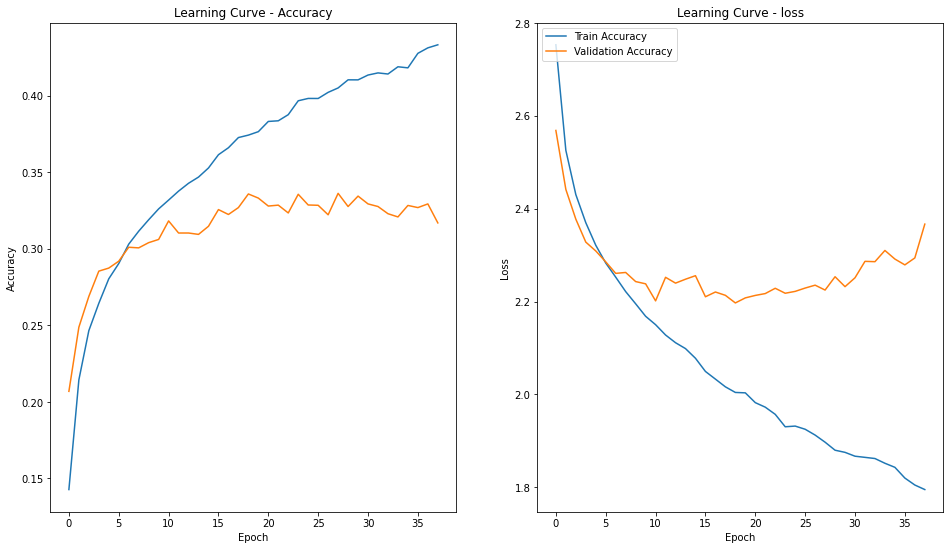

In [6]:
plotlearningcurve(history)

Underfitting as accuracy is low at 45% after 35 epochs

Also Overfitting as validation loss increases after 20 epochs while the training loss remains the same

